In [2]:
# https://blog.csdn.net/weixin_44615820/article/details/88693275
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['simhei']
mpl.rcParams['font.serif'] = ['simhei']
plt.rc("font",family="SimHei",size="14")

sns.set_style("darkgrid")
cancer=pd.read_csv("./data/breast-cancer-train.csv")
cancer.columns=['class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat']
cancer.head()
#cancer.info()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,40-49,premeno,0-4,0-2,no,3,left,central,no
1,no-recurrence-events,50-59,ge40,25-29,0-2,no,2,left,left_low,no
2,no-recurrence-events,60-69,lt40,10-14,0-2,no,1,left,right_up,no
3,no-recurrence-events,50-59,ge40,25-29,0-2,no,3,left,right_up,no
4,no-recurrence-events,40-49,premeno,30-34,0-2,no,3,left,left_up,no


In [3]:
cancer.loc[cancer["class"]=="no-recurrence-events","class"]=1
cancer.loc[cancer["class"]=="recurrence-events","class"]=0

cancer.loc[cancer["menopause"]=="premeno","menopause"]=0
cancer.loc[cancer["menopause"]=="lt40","menopause"]=1
cancer.loc[cancer["menopause"]=="ge40","menopause"]=2

cancer.loc[cancer["node-caps"]=="no","node-caps"]=0
cancer.loc[cancer["node-caps"]=="yes","node-caps"]=1
cancer.loc[cancer["node-caps"]=="?","node-caps"]=1
#node-caps结节冒未知就当做有

cancer.loc[cancer["irradiat"]=="no","irradiat"]=1
cancer.loc[cancer["irradiat"]=="yes","irradiat"]=0

cancer=cancer.drop(['breast'],axis=1)
cancer.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat
0,1,40-49,0,0-4,0-2,0,3,central,1
1,1,50-59,2,25-29,0-2,0,2,left_low,1
2,1,60-69,1,10-14,0-2,0,1,right_up,1
3,1,50-59,2,25-29,0-2,0,3,right_up,1
4,1,40-49,0,30-34,0-2,0,3,left_up,1


<AxesSubplot:xlabel='irradiat', ylabel='class'>

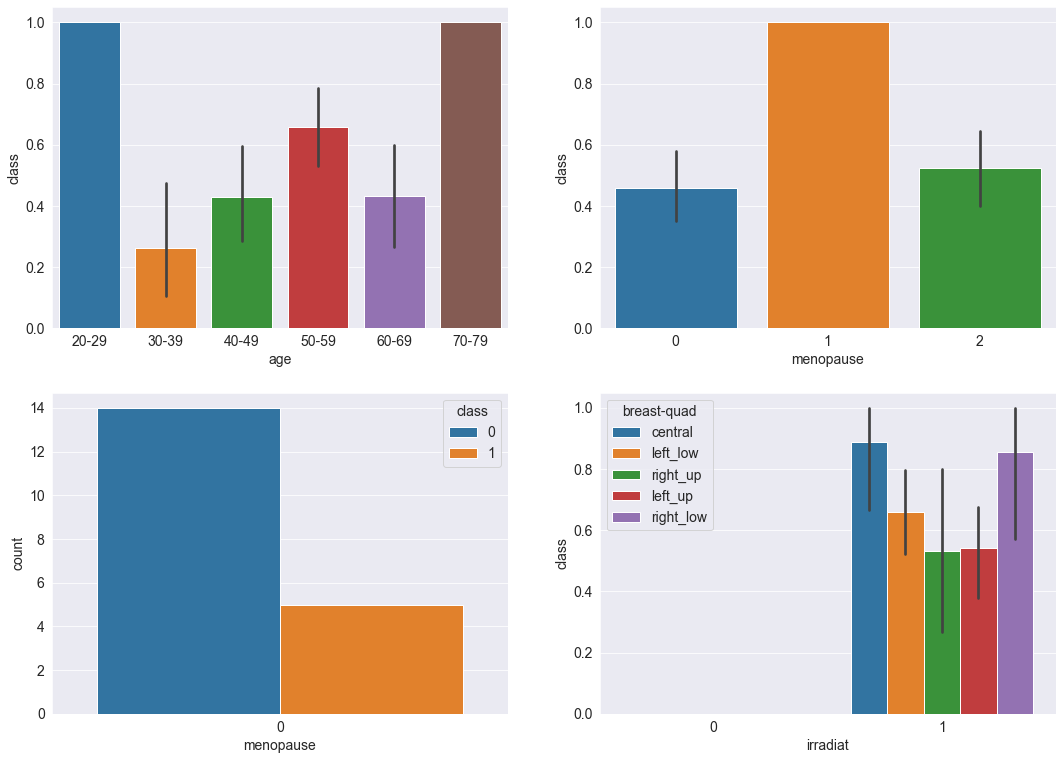

In [4]:
fig,axes = plt.subplots(2,2,figsize=(18,13))
sns.barplot(x='age',y='class',data=cancer,ax=axes[0,0],order=["20-29","30-39","40-49","50-59","60-69","70-79"])
sns.barplot(x='menopause',y='class',data=cancer,ax=axes[0,1])
sns.countplot(x='menopause',hue='class',data=cancer[cancer.age.isin(['30-39'])],ax=axes[1,0])
sns.barplot(x='irradiat',y='class',hue='breast-quad',data=cancer,ax=axes[1,1])

<AxesSubplot:xlabel='node-caps', ylabel='class'>

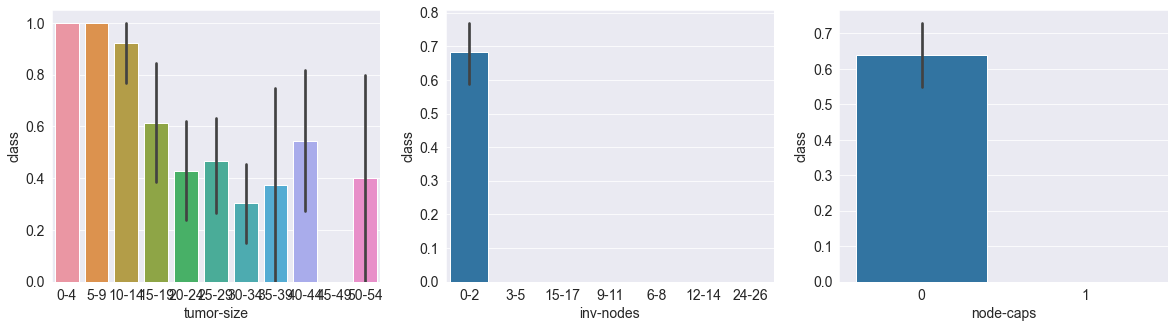

In [5]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

sns.barplot(x='tumor-size',y='class',data=cancer,order=['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54'],ax=ax1)
sns.barplot(x='inv-nodes',y='class',data=cancer,ax=ax2)
sns.barplot(x='node-caps',y='class',data=cancer,ax=ax3)

<AxesSubplot:xlabel='deg-malig', ylabel='class'>

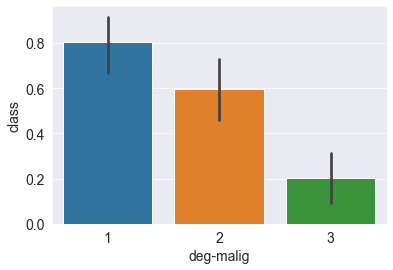

In [6]:
sns.barplot(x='deg-malig',y='class',data=cancer)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

features = ['age','tumor-size','inv-nodes','breast-quad']
#print("encoding....")
for feature in features:  
    #非数字型和数字型标签值标准化
    le.fit(cancer[feature])
    cancer[feature] = le.transform(cancer[feature])
#print("over....")
cancer.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat
0,1,2,0,0,0,0,3,0,1
1,1,3,2,4,0,0,2,1,1
2,1,4,1,1,0,0,1,4,1
3,1,3,2,4,0,0,3,4,1
4,1,2,0,5,0,0,3,2,1


In [11]:
from sklearn.model_selection import train_test_split

predictors=cancer.columns[1:]
X_train,X_test,y_train,y_test=train_test_split(cancer[predictors],cancer['class'],test_size=0.2,random_state=1)


In [12]:
###下为决策树代码
from sklearn.model_selection import GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 

max_depth=range(4,10,1) 
min_samples_split=range(2,12,1) 
min_samples_leaf=range(2,12,1) 
parameters_dtc={'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

grid_search=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=parameters_dtc,cv=10,n_jobs=-1) 
grid_search.fit(X_train,y_train.astype(int)) 
grid_search.best_params_


{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4}

In [9]:
import pydotplus
from sklearn.tree import export_graphviz

#根据调参结果构建决策树 
dtc=DecisionTreeClassifier(max_depth=5,min_samples_split=2,min_samples_leaf=9) 
dtc.fit(X_train,y_train.astype(int)) 
y_predict=dtc.predict(X_test) 

print("决策树模型在测试集上的准确率为：",metrics.accuracy_score(y_test.astype(int),y_predict.astype(int)))

###保存图像到pdf文件
dot_data = export_graphviz(dtc,out_file=None,feature_names=predictors,class_names="class",filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("cancer_tree.pdf")


决策树模型在测试集上的准确率为： 0.8620689655172413


True

In [16]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

#选择分类器的类型
RF = RandomForestClassifier()

#可以通过定义树的各种参数，限制树的大小，防止出现过拟合现象
parameters = {'n_estimators': [50,100,200], 
              'criterion': ['entropy', 'gini'],        
              'max_depth': [4,5,6], 
              'min_samples_split': [2,4,6,8],
              'min_samples_leaf': [2,4,6,8,10]
             }

#自动调参，通过交叉验证确定最优参数。
grid_obj = GridSearchCV(RF,parameters,cv=10,n_jobs=1)
grid_obj = grid_obj.fit(X_train,y_train.astype(int))

clf = grid_obj.best_estimator_
clf.fit(X_train,y_train.astype(int))


RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=50)

In [18]:
predictions = clf.predict(X_test)
print("随机森林模型在测试集上的准确率为：",accuracy_score(y_test.astype(int),predictions))

随机森林模型在测试集上的准确率为： 0.9310344827586207


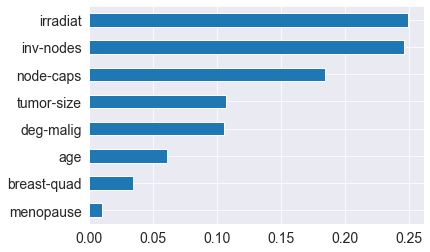

In [21]:
#影响乘客是否幸存的重要因素
importance=clf.feature_importances_
series=pd.Series(importance,index=X_train.columns)
series.sort_values(ascending=True).plot.barh()
plt.show()

In [15]:
#支持向量机
from sklearn.svm import SVC

svr=SVC()
parameters_SVM={'kernel':['rbf','linear'],'C':range(4,5,6),'gamma':[0.1,0.5,1]}

grid_SVM=GridSearchCV(svr,parameters_SVM,cv=10)
grid_SVM.fit(X_train,y_train.astype(int))
clf_SVM=grid_SVM.best_estimator_
clf_SVM.fit(X_train,y_train.astype(int))

print(clf_SVM)
print("支持向量机在训练集上的准确率为：",clf_SVM.score(X_train,y_train.astype(int)))
print("支持向量机在测试集上的准确率为：",clf_SVM.score(X_test,y_test.astype(int)))


SVC(C=4, gamma=0.1, kernel='linear')
支持向量机在训练集上的准确率为： 0.831858407079646
支持向量机在测试集上的准确率为： 0.9310344827586207
